# <center>Описание проекта</center>

<b><center>Telecom</center></b>
    
<center>Оператор связи "Ниединогоразрыва.ком" хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.</center>

<b><center>Описание услуг</center></b>

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, "цифорвая абонентская линия") или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);

* Выделенная линия технической поддержки (TechSupport);

* Облачное хранилище файлов для резревного копирования данных (OnlineBackup);

* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1-2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b><center>Описание данных</center></b>

Данные состоят из файлов, полученных из разных источников:

* ***contract.csv*** - информация о договоре;

* ***personal.csv*** - персональные данные клиента;

* ***internet.csv*** - информация об интернет-услугах;

* ***phone.csv*** - информация об услугах телефонии.

# Содержание:
* [Загрузка данных](#Загрузка-данных)
* [Анализ и предобработка данных](#Анализ-и-предобработка-данных)
    * [Анализ данных о контрактах](#Анализ-данных-о-контрактах)
    * [Анализ персональных данных](#Анализ-персональных-данных)
    * [Анализ данных об интернет-услугах](#Анализ-данных-об-интернет-услугах)
    * [Анализ данных об услугах телефонии](#Анализ-данных-об-услугах-телефонии)
* [План выполнения задачи](#План-выполнения-задачи)
* [Подготовка данных](#Подготовка-данных)
    * [Соединение данных](#Соединение-данных)
    * [Добавление новых признаков](#Добавление-новых-признаков)
    * [Обработка категориальных признаков](#Обработка-категориальных-признаков)
    * [Разделение датасетов и масштабирование](#Разделение-датасетов-и-масштабирование)
* [Построение и обучение модели](#Построение-и-обучение-модели)
    * [Модель Random Forest Classifier](#Модель-Random-Forest-Classifier)
    * [Модель Gradient Boosting Classifier](#Модель-Gradient-Boosting-Classifier)
    * [Модель XGBoostClassifier](#Модель-XGBoost-Classifier)
* [Выбор модели](#Выбор-модели)
* [Отчёт](#Отчёт)

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')

contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Анализ и предобработка данных

### Анализ данных о контрактах

Проанализируем данные о контрактах. <b>Данные о контрактах актуальны на 01.02.2020 г.</b>

In [2]:
contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


- ***customerID*** - идентификатор клиента;
- ***BeginDate*** - дата начала действия контракта;
- ***EndDate*** - дата окончания действия контракта;
- ***Type*** - тип контракта;
- ***PaperlessBilling*** - безналичный расчёт;
- ***PaymentMethod*** - метод платежа;
- ***MonthlyCharges*** - ежемесячная плата;
- ***TotalCharges*** - всего выплачено.

<b>Переименуем столбцы для более удобной работы с ними</b>

In [3]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                   'payment_method', 'monthly_charges', 'total_charges']

In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customer_id          7043 non-null object
begin_date           7043 non-null object
end_date             7043 non-null object
type                 7043 non-null object
paperless_billing    7043 non-null object
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Столбец "total_charges" по какой-то причине имеет тип "object". Выясним причину и изменим тип данных в этом столбце на "float".

In [5]:
for row in range(len(contract)):
    try:
        float(contract.loc[row, 'total_charges'])
    except:
        print('Значение, которое выдало ошибку: "{}" '.format(contract.loc[row, 'total_charges']))

Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 
Значение, которое выдало ошибку: " " 


Мы видим, что в данных о сумме общих выплат присутствуют пустые записи, которые не считаются NaN-значениями. Предполагаю, что это означает, что с клиента не списано еще ни рубля. Проверим и убедимся в этом, если все так, то заменим эти пустые строки на нули.

In [6]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Так и есть, пустое значение в данном столбце стоит у тех клиентов, которые заключили контракт на 01.02.2020 г. Наши данные именно от этой даты, соответственно, с клиентов еще не было ничего списано. Заменим эти значения на нули.

In [7]:
contract['total_charges'] = contract['total_charges'].replace(' ', 0)

In [8]:
contract['total_charges'] = contract['total_charges'].astype('float')

In [9]:
contract.describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


Также необходимо привести столбцы с датой к типу datetime. Строки, где не указана дата окончания договора обработаем как "пустую дату".

In [10]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors='coerce')
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customer_id          7043 non-null object
begin_date           7043 non-null datetime64[ns]
end_date             1869 non-null datetime64[ns]
type                 7043 non-null object
paperless_billing    7043 non-null object
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null float64
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


<b>Построим некоторые графики, отображающие данные</b>

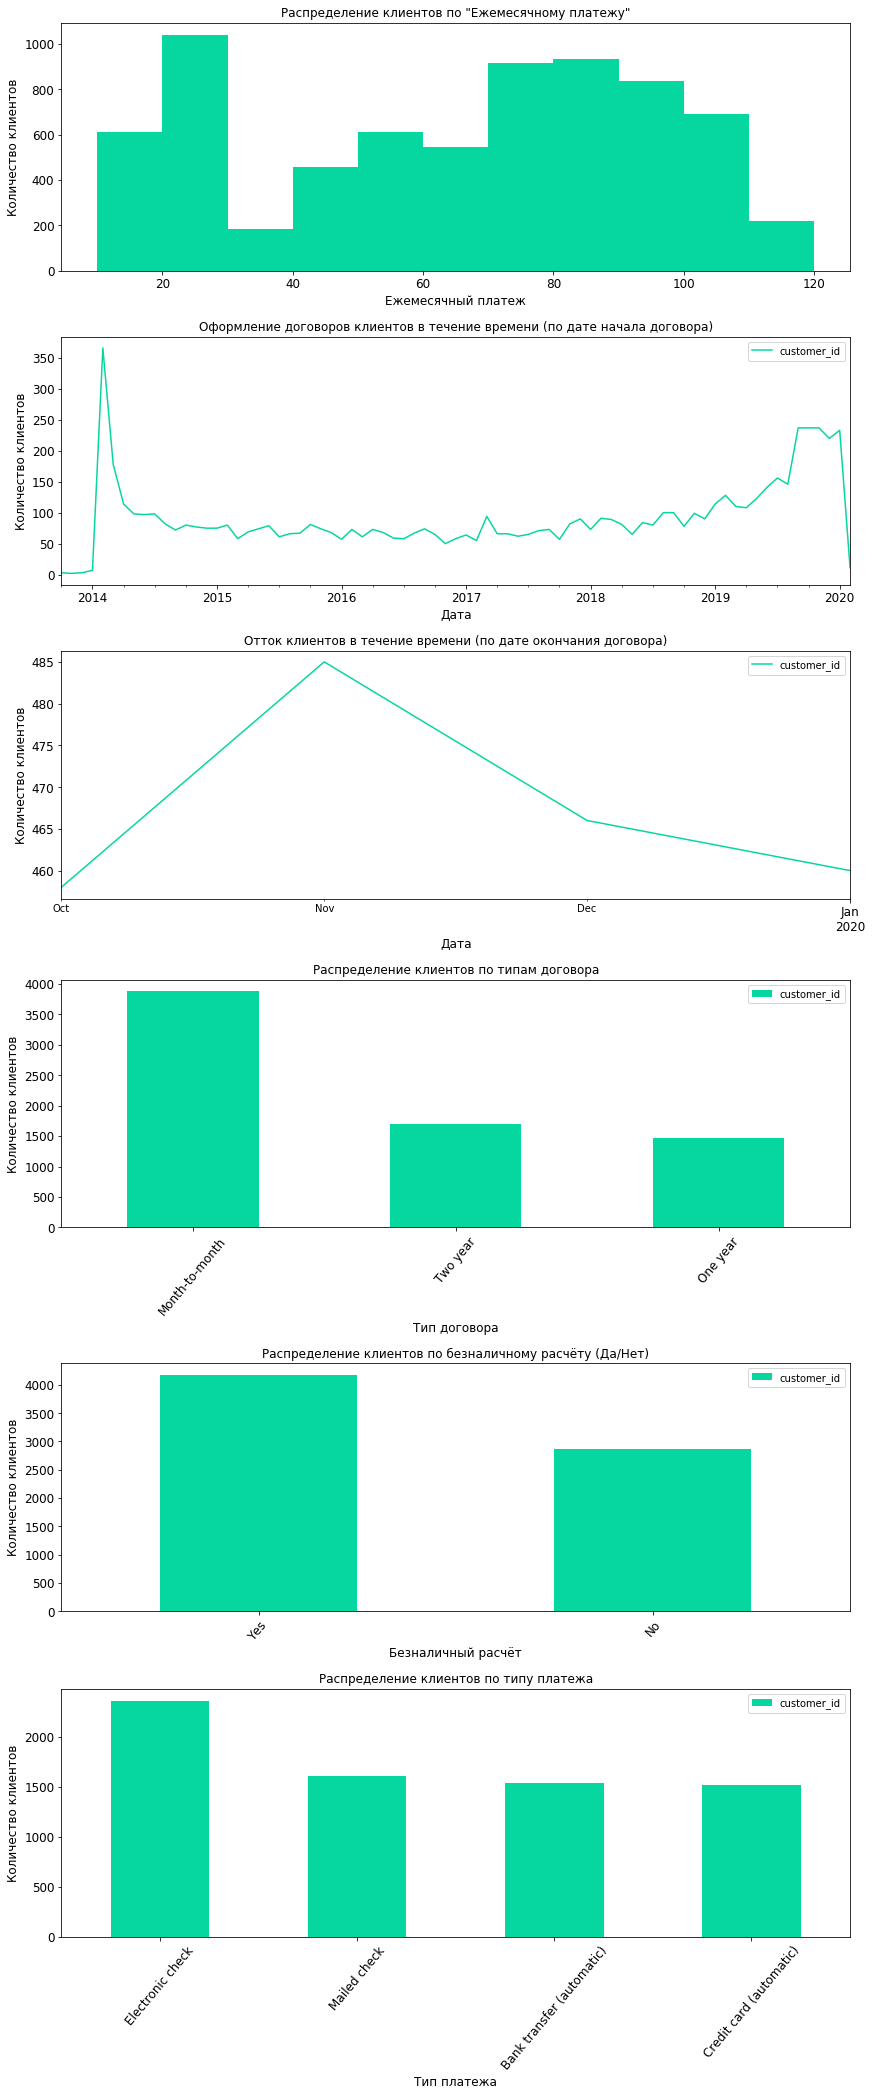

In [12]:
fig, axs = plt.subplots(6, 1, figsize=(12, 29), constrained_layout=True)

axs[0].set_title('Распределение клиентов по "Ежемесячному платежу"')
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)
contract['monthly_charges'].plot(kind='hist', ax=axs[0], color='#06D6A0', bins=[10, 20, 30, 40, 50, 60,
                                                                            70, 80, 90, 100, 110, 120]);
axs[0].set_xlabel('Ежемесячный платеж', fontsize=12);
axs[0].set_ylabel('Количество клиентов', fontsize=12);

axs[1].set_title('Оформление договоров клиентов в течение времени (по дате начала договора)')
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)
contract.pivot_table(index='begin_date', values='customer_id', aggfunc=len).plot(ax=axs[1], color='#06D6A0');
axs[1].set_xlabel('Дата', fontsize=12);
axs[1].set_ylabel('Количество клиентов', fontsize=12);

axs[2].set_title('Отток клиентов в течение времени (по дате окончания договора)')
axs[2].tick_params(axis='y', labelsize=12)
axs[2].tick_params(axis='x', labelsize=12)
contract.pivot_table(index='end_date', values='customer_id', aggfunc=len).plot(ax=axs[2], color='#06D6A0');
axs[2].set_xlabel('Дата', fontsize=12);
axs[2].set_ylabel('Количество клиентов', fontsize=12);

axs[3].set_title('Распределение клиентов по типам договора')
axs[3].tick_params(axis='y', labelsize=12)
contract.pivot_table(index='type', values='customer_id', aggfunc=len).sort_values(by='customer_id', ascending=False) \
                                                                     .plot(kind='bar', ax=axs[3], color='#06D6A0');
axs[3].tick_params(axis='x', labelsize=12, rotation=50)
axs[3].set_xlabel('Тип договора', fontsize=12);
axs[3].set_ylabel('Количество клиентов', fontsize=12);

axs[4].set_title('Распределение клиентов по безналичному расчёту (Да/Нет)')
axs[4].tick_params(axis='y', labelsize=12)
contract.pivot_table(index='paperless_billing', values='customer_id', aggfunc=len).sort_values(by='customer_id', ascending=False) \
                                                                     .plot(kind='bar', ax=axs[4], color='#06D6A0');
axs[4].tick_params(axis='x', labelsize=12, rotation=50)
axs[4].set_xlabel('Безналичный расчёт', fontsize=12);
axs[4].set_ylabel('Количество клиентов', fontsize=12);

axs[5].set_title('Распределение клиентов по типу платежа')
axs[5].tick_params(axis='y', labelsize=12)
contract.pivot_table(index='payment_method', values='customer_id', aggfunc=len).sort_values(by='customer_id', ascending=False) \
                                                                     .plot(kind='bar', ax=axs[5], color='#06D6A0');
axs[5].tick_params(axis='x', labelsize=12, rotation=50)
axs[5].set_xlabel('Тип платежа', fontsize=12);
axs[5].set_ylabel('Количество клиентов', fontsize=12);

Основываясь на графиках, можно сделать следующие выводы:

* Большинство клиентов платят ежемесячно либо от 10 до 30, либо от 70 до 110;


* Наибольший приток клиентов пришелся на 1-й квартал 2014 года. Затем приток клиентов оставался стабильным до 2019 года. С начала 2019 года приток клиентов серьезно увеличился;


* Отток клиентов пришелся только на 2019-2020 год. Наибольший показатель пришелся на Ноябрь 2019 года, тогда ушло около 485 клиентов;


* Как и следовало ожидать, наиболее популярный тип договора: Ежемесячный договор. Договоры на 1 и 2 года распределились практически одинаково;


* Большая часть клиентов рассчитываются безналичным способом;


* Наиболее популярный метод платежа: Электронный чек. Остальные методы платежа распределились одинаково.

<b>Вывод:</b> Пропущенные значения в данных о контрактах находятся только в столбце "end_date", они означают, что контракт еще не разорван/не истек срок его действия. В остальных столбцах пропущенных значений не наблюдается. Столбцы переименованы в более удобный вид. Типы данных приведены к необходимым. 

Средняя ежемесячная плата клиентов: 64.76;

Средняя сумма всех выплат клиентов: 2279.73.

### Анализ персональных данных

In [13]:
personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


- ***customerID*** - идентификатор клиента;
- ***gender*** - пол клиента;
- ***SeniorCitizen*** - 1 - пенсионер / 0 - не пенсионер;
- ***Partner*** - вероятно флаг "супруга". Yes - есть супруг, No - нет супруга;
- ***Dependents*** - флаг "иждивенцов", вероятно речь идет о детях. Yes - есть, No - нет.

<b>Переименуем столбцы для более удобной работы с ними</b>

In [14]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [15]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customer_id       7043 non-null object
gender            7043 non-null object
senior_citizen    7043 non-null int64
partner           7043 non-null object
dependents        7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<b>Построим графики, отобрающие данные</b>

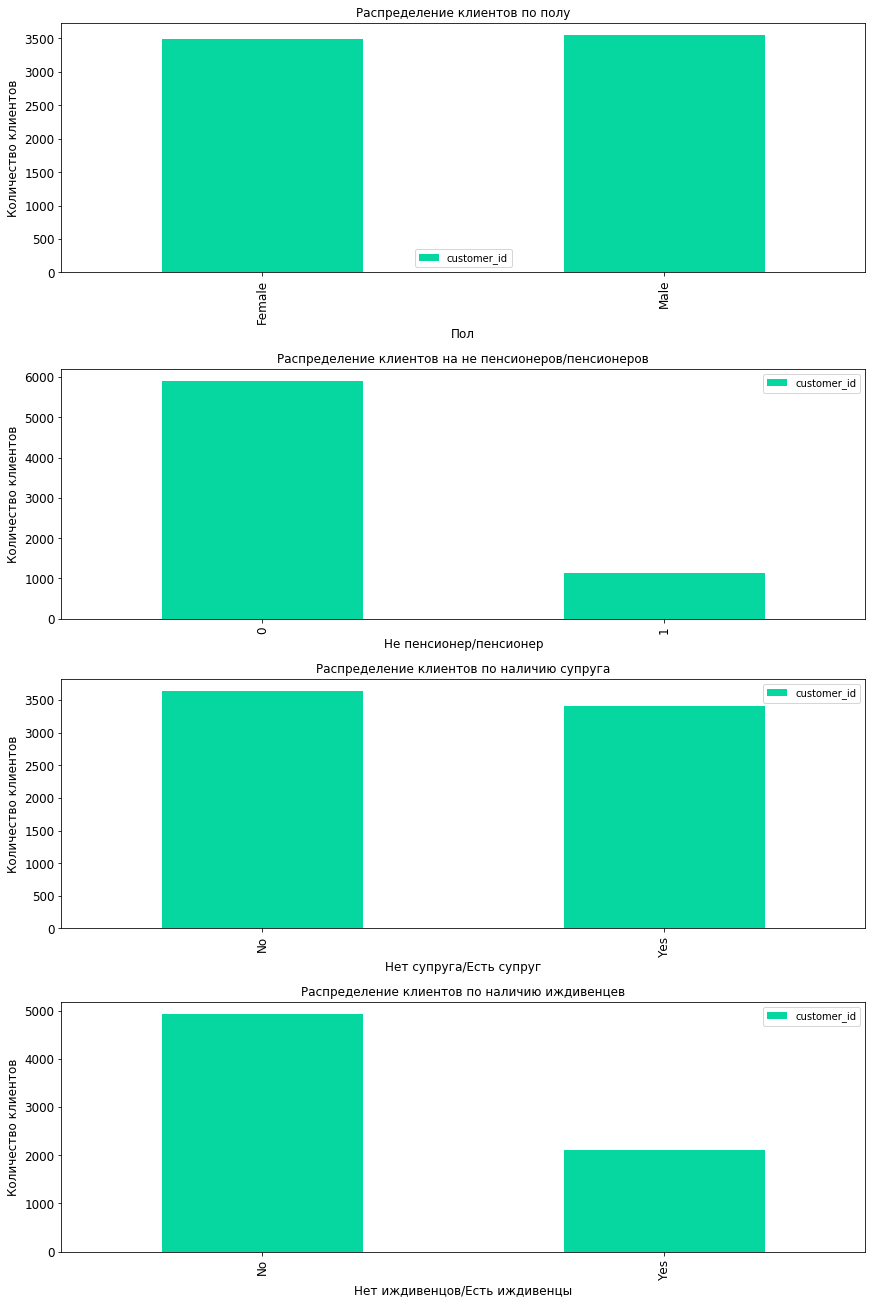

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(12, 18), constrained_layout=True)

axs[0].set_title('Распределение клиентов по полу')
axs[0].tick_params(axis='y', labelsize=12)
axs[0].tick_params(axis='x', labelsize=12)
personal.pivot_table(index='gender', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[0], color='#06D6A0');
axs[0].set_xlabel('Пол', fontsize=12);
axs[0].set_ylabel('Количество клиентов', fontsize=12);

axs[1].set_title('Распределение клиентов на не пенсионеров/пенсионеров')
axs[1].tick_params(axis='y', labelsize=12)
axs[1].tick_params(axis='x', labelsize=12)
personal.pivot_table(index='senior_citizen', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[1], color='#06D6A0');
axs[1].set_xlabel('Не пенсионер/пенсионер', fontsize=12);
axs[1].set_ylabel('Количество клиентов', fontsize=12);

axs[2].set_title('Распределение клиентов по наличию супруга')
axs[2].tick_params(axis='y', labelsize=12)
axs[2].tick_params(axis='x', labelsize=12)
personal.pivot_table(index='partner', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[2], color='#06D6A0');
axs[2].set_xlabel('Нет супруга/Есть супруг', fontsize=12);
axs[2].set_ylabel('Количество клиентов', fontsize=12);

axs[3].set_title('Распределение клиентов по наличию иждивенцев')
axs[3].tick_params(axis='y', labelsize=12)
axs[3].tick_params(axis='x', labelsize=12)
personal.pivot_table(index='dependents', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[3], color='#06D6A0');
axs[3].set_xlabel('Нет иждивенцов/Есть иждивенцы', fontsize=12);
axs[3].set_ylabel('Количество клиентов', fontsize=12);

Основываясь на графиках, можно сделать следующие выводы:

* Среди клиентов примерно одинаковое количество мужчин и женщин;

* Большинство клиентов не являются пенсионерами. 1142 из 7043 клиентов являются пенсионерами;

* Количество клиентов без супруга немного превышает количество клиентов с супругом;

* Большинство клиентов не имеют иждивенцов. Около 2200 клиентов из 7043 имеют иждивценов.

<b>Вывод:</b> Пропущенных значений в данных не наблюдается. Данные имеют необходимый тип (на данный момент). Среди 7043 клиентов пенсионерами являются 1142 человека. Распределение по полу близится к 50/50.

### Анализ данных об интернет-услугах

In [17]:
internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


- ***customerID*** - идентификатор клиента;
- ***InternetService*** - тип подключения Интернета;
- ***OnlineSecurity*** - наличие услуги: Блокировка небезопасных сайтов;
- ***OnlineBackup*** - наличие услуги: Облачное храналище для резервного копирования данных;
- ***DeviceProtection*** - наличие услуги: Антивирус;
- ***TechSupport*** - наличие услуги: Выделенная линия технической поддержки;
- ***StreamingTV*** - наличие услуги: Стриминговое телевидение;
- ***StreamingMovies*** - наличие услуги: Каталог фильмов.

<b>Переименуем столбцы для более удобной работы с ними</b>

In [18]:
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [19]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customer_id          5517 non-null object
internet_service     5517 non-null object
online_security      5517 non-null object
online_backup        5517 non-null object
device_protection    5517 non-null object
tech_support         5517 non-null object
streaming_tv         5517 non-null object
streaming_movies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


<b>Построим графики, отображающие наши данные</b>

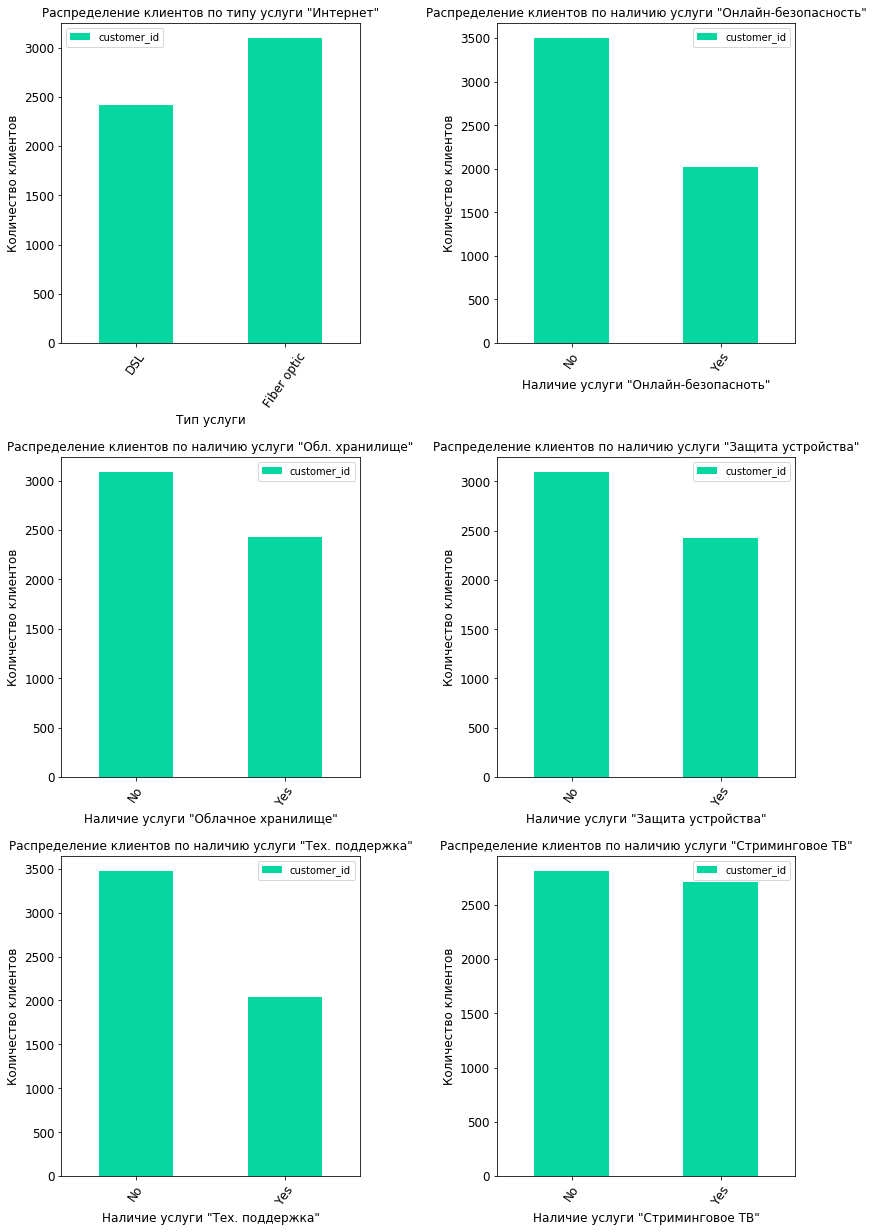

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(12, 17), constrained_layout=True)

axs[0][0].set_title('Распределение клиентов по типу услуги "Интернет"')
axs[0][0].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='internet_service', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[0][0], color='#06D6A0');
axs[0][0].set_xlabel('Тип услуги', fontsize=12);
axs[0][0].set_ylabel('Количество клиентов', fontsize=12);
axs[0][0].tick_params(axis='x', labelsize=12, rotation=55)

axs[0][1].set_title('Распределение клиентов по наличию услуги "Онлайн-безопасность"')
axs[0][1].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='online_security', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[0][1], color='#06D6A0');
axs[0][1].set_xlabel('Наличие услуги "Онлайн-безопасноть"', fontsize=12);
axs[0][1].set_ylabel('Количество клиентов', fontsize=12);
axs[0][1].tick_params(axis='x', labelsize=12, rotation=55)

axs[1][0].set_title('Распределение клиентов по наличию услуги "Обл. хранилище"')
axs[1][0].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='online_backup', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[1][0], color='#06D6A0');
axs[1][0].set_xlabel('Наличие услуги "Облачное хранилище"', fontsize=12);
axs[1][0].set_ylabel('Количество клиентов', fontsize=12);
axs[1][0].tick_params(axis='x', labelsize=12, rotation=55)

axs[1][1].set_title('Распределение клиентов по наличию услуги "Защита устройства"')
axs[1][1].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='device_protection', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[1][1], color='#06D6A0');
axs[1][1].set_xlabel('Наличие услуги "Защита устройства"', fontsize=12);
axs[1][1].set_ylabel('Количество клиентов', fontsize=12);
axs[1][1].tick_params(axis='x', labelsize=12, rotation=55)

axs[2][0].set_title('Распределение клиентов по наличию услуги "Тех. поддержка"')
axs[2][0].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='tech_support', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[2][0], color='#06D6A0');
axs[2][0].set_xlabel('Наличие услуги "Тех. поддержка"', fontsize=12);
axs[2][0].set_ylabel('Количество клиентов', fontsize=12);
axs[2][0].tick_params(axis='x', labelsize=12, rotation=55)

axs[2][1].set_title('Распределение клиентов по наличию услуги "Стриминговое ТВ"')
axs[2][1].tick_params(axis='y', labelsize=12)
internet.pivot_table(index='streaming_tv', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs[2][1], color='#06D6A0');
axs[2][1].set_xlabel('Наличие услуги "Стриминговое ТВ"', fontsize=12);
axs[2][1].set_ylabel('Количество клиентов', fontsize=12);
axs[2][1].tick_params(axis='x', labelsize=12, rotation=55)

In [21]:
print('Соотношение клиентов по наличию услуги "Онлайн-безопаность": {:.1f}% - Нет услуги / {:.1f}% - Есть услуга'
      .format(len(internet[internet['online_security'] == 'No']) / len(internet) * 100,
             len(internet[internet['online_security'] == 'Yes']) / len(internet) * 100))

print('Соотношение клиентов по наличию услуги "Облачное хранилище": {:.1f}% - Нет услуги / {:.1f}% - Есть услуга'
      .format(len(internet[internet['online_backup'] == 'No']) / len(internet) * 100,
             len(internet[internet['online_backup'] == 'Yes']) / len(internet) * 100))

print('Соотношение клиентов по наличию услуги "Защита устройства": {:.1f}% - Нет услуги / {:.1f}% - Есть услуга'
      .format(len(internet[internet['device_protection'] == 'No']) / len(internet) * 100,
             len(internet[internet['device_protection'] == 'Yes']) / len(internet) * 100))

print('Соотношение клиентов по наличию услуги "Тех. поддержка": {:.1f}% - Нет услуги / {:.1f}% - Есть услуга'
      .format(len(internet[internet['tech_support'] == 'No']) / len(internet) * 100,
             len(internet[internet['tech_support'] == 'Yes']) / len(internet) * 100))

print('Соотношение клиентов по наличию услуги "Стриминговое ТВ": {:.1f}% - Нет услуги / {:.1f}% - Есть услуга'
      .format(len(internet[internet['streaming_tv'] == 'No']) / len(internet) * 100,
             len(internet[internet['streaming_tv'] == 'Yes']) / len(internet) * 100))

print('Количество клиентов, которые не пользовались интернет-услугами:', len(contract) - len(internet))

Соотношение клиентов по наличию услуги "Онлайн-безопаность": 63.4% - Нет услуги / 36.6% - Есть услуга
Соотношение клиентов по наличию услуги "Облачное хранилище": 56.0% - Нет услуги / 44.0% - Есть услуга
Соотношение клиентов по наличию услуги "Защита устройства": 56.1% - Нет услуги / 43.9% - Есть услуга
Соотношение клиентов по наличию услуги "Тех. поддержка": 63.0% - Нет услуги / 37.0% - Есть услуга
Соотношение клиентов по наличию услуги "Стриминговое ТВ": 50.9% - Нет услуги / 49.1% - Есть услуга
Количество клиентов, которые не пользовались интернет-услугами: 1526


Основываясь на графкиках, можно сделать следующие выводы:

* Большинство клиентов предполчитают тип подключения интернета "Fiber optic", действительно, сейчас это наиболее популярный тип подключения;


* Большинство клинетов не подключали себе услугу "Онлайн-безопасность" 63.4%/36.6%;


* Большинство клиентов не подключали себе услугу "Облачное хранилище" 56.0%/44.0%;


* Большинство клиентов не подключали себе услугу "Защита устройства" 56.1%/43.9%;


* Большинство клиентов не подключали себе услугу "Тех. поддержка" 63.0%/37.0%;


* Примерно половина клиентов подключили себе услугу "Стриминговое ТВ" 50.9% / 49.1%;


* 1526 клиентов не пользовались интернет-услугами вовсе.

<b>Вывод:</b> Столбцы переименованы. Пропущенных значений не наблюдается. Все значения являются строковыми.

<b>Важно отметить, что в этом датасете присутствуют данные об интернет-услугах только по 5517 клиентам из 7043.</b>

### Анализ данных об услугах телефонии

In [22]:
phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


- ***customerID*** - идентификатор клиента;
- ***MultipleLines*** - подключение телефонного аппарата к одной линии одновременно: No - нет, Yes - Да

<b>Переименуем столбцы для более удобной работы</b>

In [23]:
phone.columns = ['customer_id', 'multiple_lines']

In [24]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customer_id       6361 non-null object
multiple_lines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Пропущенных данных не наблюдается.

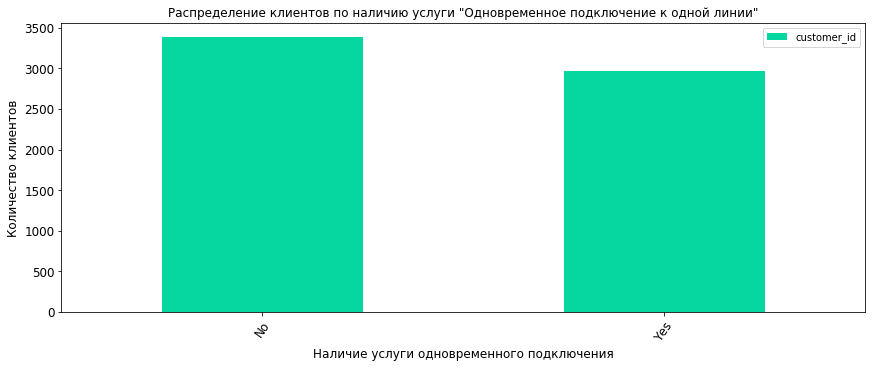

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)

axs.set_title('Распределение клиентов по наличию услуги "Одновременное подключение к одной линии"')
axs.tick_params(axis='y', labelsize=12)
phone.pivot_table(index='multiple_lines', values='customer_id', aggfunc=len).plot(kind='bar', ax=axs, color='#06D6A0');
axs.set_xlabel('Наличие услуги одновременного подключения', fontsize=12);
axs.set_ylabel('Количество клиентов', fontsize=12);
axs.tick_params(axis='x', labelsize=12, rotation=55)

In [26]:
print('Соотношение клиентов с услугой и без: {:.1f}% - нет услуги / {:.1f}% - есть услуга'.format(len(phone[phone['multiple_lines'] == 'No']) / len(phone) * 100, len(phone[phone['multiple_lines'] == 'Yes']) / len(phone) * 100))

Соотношение клиентов с услугой и без: 53.3% - нет услуги / 46.7% - есть услуга


<b>Вывод:</b> Пропущенных значений в данном датасете не найдено. Столбцы переименованы. 53% клиентов не оформляли себе услугу одновременного подключения к одной линии.

<b>Важно заметить, что в этом датасете присутствует информация только о 6361 клиенте из 7043. Вероятно, те клиенты, о которых нет информации, не пользовались услугами мобильной связи от данного оператора вовсе.</b>

## План выполнения задачи

1. Провести подробный исследовательский анализ данных. Провести обработку пропущенных значений. Проверить данные на наличие выбросов.


2. Разметить данные на "Клиент ушел" и "Клиент не ушел" путем создания столбца "client_left", который присваивал бы класс клиенту. 1 - ушел, 0 - не ушел. Ушедших клиентов буду определять по столбцу "end_date", если там стоит какая-либо дата, значит клиент отказался от услуг оператора.


3. Проведу изменение типов данных для дальнейшего обучения модели. Категориальные данные приведу в числовой тип методом One-Hot-Encoding.


4. Разделю данные на обучающую, валидационную и тестовую выборки. Проведу масштабирование данных.


5. Создам модель и обучу ее, буду оценивать ее метрикой "Accuracy" и "ROC-AUC".


6. Затем проведу тщательную настройку гиперпараметров модели с помощью GridSearchCV или RandomizedSearchCV.


7. Выполню предсказание модели на тестовых данных и предоставлю результаты.

Отчёт:

* [Отчёт](#Отчёт)

## Подготовка данных

### Соединение данных

Для начала соединим данные в один датасет.

In [27]:
data = contract.merge(personal)
data = data.merge(internet, how='outer')
data = data.merge(phone, how='outer')

### Добавление новых признаков

Затем проставим признак "клиент ушел" в столбце "client_left".

In [28]:
def client_left(dt):
    if pd.isna(dt):
        return 0
    else:
        return 1
    
data['client_left'] = data['end_date'].apply(client_left)

Добавим новый признак под названием "life_cycle", то есть цикл жизни клиента. Будем считать его вычитая из "end_date" значение "begin_date". Если значение "end_date" пустое, тогда заполним его 01.02.2020 г., так как данные актуализированы на эту дату.

In [29]:
data['lifetime'] = (data['end_date'].fillna(pd.to_datetime('2020-02-01')) - data['begin_date']).dt.days

In [30]:
data.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,lifetime
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,61


Затем начала уберем из данных столбцы "end_date", "begin_date" и "customer_id"

In [31]:
data_all = data.drop(['begin_date', 'end_date', 'customer_id'], axis=1)

In [32]:
data_all.head(3)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,lifetime
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61


In [33]:
data_all.shape

(7043, 19)

### Обработка категориальных признаков

Обработка категориальных признаков будет происходить по методу One-Hot-Encoding.

In [34]:
data_ohe = pd.get_dummies(data_all, drop_first=True)#, dummy_na=True)

In [35]:
data_ohe.dtypes

monthly_charges                           float64
total_charges                             float64
senior_citizen                              int64
client_left                                 int64
lifetime                                    int64
type_One year                               uint8
type_Two year                               uint8
paperless_billing_Yes                       uint8
payment_method_Credit card (automatic)      uint8
payment_method_Electronic check             uint8
payment_method_Mailed check                 uint8
gender_Male                                 uint8
partner_Yes                                 uint8
dependents_Yes                              uint8
internet_service_Fiber optic                uint8
online_security_Yes                         uint8
online_backup_Yes                           uint8
device_protection_Yes                       uint8
tech_support_Yes                            uint8
streaming_tv_Yes                            uint8


Все данные приведены к числовому типу.

In [36]:
data_ohe.shape

(7043, 22)

In [37]:
data_ohe.head(4)

,monthly_charges,total_charges,senior_citizen,client_left,lifetime,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,...,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,29.85,29.85,0,0,31,0,0,1,0,1,...,1,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,0,1036,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,0,1,61,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,0,1371,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0


Рассмотрим корреляцию признаков и определим наиболее эффективные признаки. Составим таблицу корреляции для нашего датасета, приведем все значения к положительным, отсортируем по убыванию и выберем самые коррелирующие признаки.

In [38]:
abs(data_ohe[['monthly_charges', 'total_charges', 'lifetime', 'client_left']].corr()['client_left']).sort_values(ascending=False)

client_left        1.000000
lifetime           0.352673
total_charges      0.198324
monthly_charges    0.193356
Name: client_left, dtype: float64

Итак, мы можем наблюдать, что новый фактор, который мы создали, коррелируют с целевым признаком.

In [39]:
features_ = ['monthly_charges', 'total_charges', 'senior_citizen',
       'lifetime', 'type_One year', 'type_Two year', 'paperless_billing_Yes',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'gender_Male', 'partner_Yes', 'dependents_Yes',
       'internet_service_Fiber optic', 'online_security_Yes',
       'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes',
       'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes']

quant_features = ['monthly_charges', 'total_charges', 'lifetime']

### Разделение датасетов и масштабирование

In [40]:
#features = data_ohe.drop('client_left', axis=1)
features = data_ohe[features_]
target = data_ohe['client_left']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, train_size=0.6, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345, stratify=target_valid)

my_scaler = StandardScaler()
features_train[quant_features] = my_scaler.fit_transform(features_train[quant_features])
features_valid[quant_features] = my_scaler.transform(features_valid[quant_features])
features_test[quant_features] = my_scaler.transform(features_test[quant_features])

features_train = pd.DataFrame(features_train, columns=features.columns)
features_valid = pd.DataFrame(features_valid, columns=features.columns)
features_test = pd.DataFrame(features_test, columns=features.columns)


#gbm0 = GradientBoostingClassifier(random_state=10)
#modelfit(gbm0, features_train, target_train)

In [41]:
features_train.head(3)

,monthly_charges,total_charges,senior_citizen,lifetime,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
6295,-1.483755,-0.570832,0,0.611804,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
6630,0.458464,-0.486927,1,-0.683333,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
888,0.871454,0.404530,0,0.165894,1,0,0,1,0,0,...,1,1,1,0,0,0,0,1,1,0


In [42]:
features_test.head(3)

,monthly_charges,total_charges,senior_citizen,lifetime,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,partner_Yes,dependents_Yes,internet_service_Fiber optic,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
5007,-1.470486,-0.784218,0,-0.319949,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2576,1.437036,1.585151,0,0.815459,0,0,1,0,0,0,...,1,1,1,0,1,1,1,1,1,0
409,-1.503658,-1.013485,0,-1.292965,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Данные разделены, теперь перейдём к созданию и обучению модели.

## Построение и обучение модели

Для начала разработаю функцию, которая будет принимать в качестве аругментов: модель, обучающую выборку, целевой признак обучающей выборки.

Переданная в качестве аргумента модель будет обучаться на обучающей выборке. Затем совершать предсказание для этой же обучающей выборки. Затем модель будет проходить кросс-валидацию с параметром cv=5 (данный параметр можно изменить, передав соответствующий аргумент в функцию). По итогу всех операций с моделью будет выведены следующие значения:

* Значение метрики Accuracy на обучающей выборке;

* Значение метрики ROC-AUC на обучающей выборке;

* Значения метрики ROC-AUC после кросс-валидации на обучающей выборке;

* Значения метрики Accuracy после кросс-валидации на обучающей выборке;

* Feature Importances в виде графика типа bar.

In [43]:
def modelfit(alg, features_train, target_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Обучение модели
    alg.fit(features_train, target_train)
        
    # Предсказание модели на обучающей выборке:
    train_predictions = alg.predict(features_train)
    train_predprob = alg.predict_proba(features_train)[:,1]
    #valid_predictions = alg.predict(features_valid)
    #valid_predprob = alg.predict_proba(features_valid)[:,1]
    
    # Кросс-валидация:
    if performCV:
        cv_score = cross_val_score(alg, features_train, target_train, cv=cv_folds, scoring='roc_auc')
        cv_score_acc = cross_val_score(alg, features_train, target_train, cv=cv_folds, scoring='accuracy')
    
    print ("\nModel Report")
    print ("Accuracy (train) : %.4g" % metrics.accuracy_score(target_train.values, train_predictions))
    #print ("Accuracy (valid) : %.4g" % metrics.accuracy_score(target_valid.values, valid_predictions))
    print ("ROC-AUC Score (Train): %f" % metrics.roc_auc_score(target_train, train_predprob))
    #print ("AUC Score (Valid): %f" % metrics.roc_auc_score(target_valid, valid_predprob))
           
    if performCV:
        print ("CV Score ROC-AUC: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print ("CV Score Accuracy: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score_acc),np.std(cv_score_acc),np.min(cv_score_acc),np.max(cv_score_acc)))
        
    # Feature Importances:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, features_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Опробуем несколько моделей:

* Random Forest Classifier;

* Gradient Boosting Classifier;

* XGBoost Classifier.

### Модель Random Forest Classifier

Начнем с модели Random Forest Classifier. Feature Importances пока выводить не будем.

In [44]:
model = RandomForestClassifier(random_state=10)
modelfit(model, features_train, target_train, printFeatureImportance=False)


Model Report
Accuracy (train) : 0.9851
ROC-AUC Score (Train): 0.999140
CV Score ROC-AUC: Mean - 0.8171543 | Std - 0.01799442 | Min - 0.7872336 | Max - 0.8387969
CV Score Accuracy: Mean - 0.7957328 | Std - 0.01345104 | Min - 0.7725118 | Max - 0.8130178


Проверим самую простую модель на валидационной выборке.

In [45]:
model.fit(features_train, target_train)
preds_proba = model.predict_proba(features_valid)[:,1]
print('Метрика ROC-AUC на валидационной выборке:', metrics.roc_auc_score(target_valid, preds_proba))

Метрика ROC-AUC на валидационной выборке: 0.8027616316618875


Мы видим, что метрика ROC-AUC на валидационной выборке невелика. Попробуем настроить гиперпараметры с помощью GridSearchCV.

Разработаем функцию, которая будет подбирать гиперпараметры к нашей модели с помощью GridSearchCV.

In [46]:
def tuning(model, params_list, features_train, target_train):
    for params_dict in params_list:
        print('Производится настройка параметра: {}'.format(list(params_dict.keys())[0]))
        gsearch = GridSearchCV(estimator = model,
                        param_grid = params_dict, scoring='roc_auc', n_jobs=4, cv=5, verbose=10)
        gsearch.fit(features_train, target_train)
        print('Оптимальное значение параметра "{}" равно {}'.format(list(params_dict.keys())[0], gsearch.best_params_))
        model = gsearch.best_estimator_
    return model

In [47]:
params_list = [
    {'n_estimators': [i for i in range(150, 300, 10)]},
    {'max_depth': [i for i in range(1, 50, 5)]},
    {'min_samples_split': [i for i in range(2, 20, 1)]},
    {'min_samples_leaf': [i for i in range(2, 15, 1)]},
    {'max_leaf_nodes': [i for i in range(2, 10, 1)]},
    {'min_weight_fraction_leaf': np.arange(0, 0.6, 0.1)},
    {'min_impurity_decrease': np.arange(0, 0.6, 0.1)}
]

model = RandomForestClassifier(random_state=10)

model = tuning(model, params_list, features_train, target_train)

Производится настройка параметра: n_estimators
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   56.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  1.4min finished


Оптимальное значение параметра "n_estimators" равно {'n_estimators': 290}
Производится настройка параметра: max_depth
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   57.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.1min finished


Оптимальное значение параметра "max_depth" равно {'max_depth': 6}
Производится настройка параметра: min_samples_split
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   53.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.5min finished


Оптимальное значение параметра "min_samples_split" равно {'min_samples_split': 12}
Производится настройка параметра: min_samples_leaf
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:  1.0min finished


Оптимальное значение параметра "min_samples_leaf" равно {'min_samples_leaf': 3}
Производится настройка параметра: max_leaf_nodes
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done  38 out of  40 | elapsed:   30.6s remaining:    1.6s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   31.0s finished


Оптимальное значение параметра "max_leaf_nodes" равно {'max_leaf_nodes': 9}
Производится настройка параметра: min_weight_fraction_leaf
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   12.6s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:   17.7s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   18.8s finished


Оптимальное значение параметра "min_weight_fraction_leaf" равно {'min_weight_fraction_leaf': 0.0}
Производится настройка параметра: min_impurity_decrease
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:   21.6s remaining:    2.4s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   22.6s finished


Оптимальное значение параметра "min_impurity_decrease" равно {'min_impurity_decrease': 0.0}


Проверим настроенную модель.


Model Report
Accuracy (train) : 0.8059
ROC-AUC Score (Train): 0.862396
CV Score ROC-AUC: Mean - 0.8511068 | Std - 0.01272383 | Min - 0.8363767 | Max - 0.8717578
CV Score Accuracy: Mean - 0.7983467 | Std - 0.009811431 | Min - 0.7836879 | Max - 0.8094675


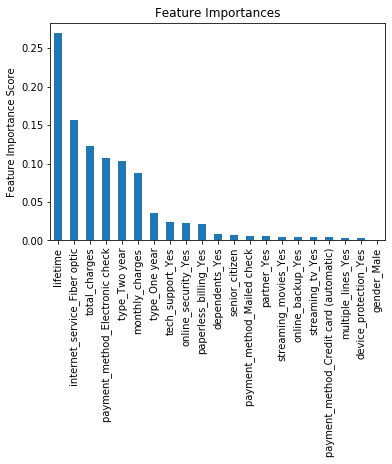

In [48]:
modelfit(model, features_train, target_train)

Мы можем увидеть, что значение метрики ROC-AUC выросло.

Также проверим модель на валидационной выборке.

In [49]:
rfc_model = model

model.fit(features_train, target_train)

preds_proba = model.predict_proba(features_valid)[:,1]
print('ROC-AUC score (test): ', metrics.roc_auc_score(target_valid, preds_proba))

ROC-AUC score (test):  0.838709344080188


<b>Вывод:</b> Значение метрики ROC-AUC модели Random Forest Classifier с настроенными параметрами 0.838, это не впечатляющий результат. Перейдём к следующей модели.

### Модель Gradient Boosting Classifier

In [50]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, features_train, target_train, printFeatureImportance=False)


Model Report
Accuracy (train) : 0.8528
ROC-AUC Score (Train): 0.911109
CV Score ROC-AUC: Mean - 0.8813984 | Std - 0.0124346 | Min - 0.8676087 | Max - 0.9015521
CV Score Accuracy: Mean - 0.8314803 | Std - 0.01236401 | Min - 0.8191489 | Max - 0.8544379


In [51]:
gbm0.fit(features_train, target_train)

preds_proba = gbm0.predict_proba(features_valid)[:,1]
print('ROC-AUC score (valid): ', metrics.roc_auc_score(target_valid, preds_proba))

ROC-AUC score (valid):  0.870257562840683


Значение метрики ROC-AUC на валидационной выборке 0.87, это уже больше, чем у Random Forest. Приступим к настройке параметров.

In [52]:
params_list = [
    {'n_estimators': [i for i in range(250, 350, 10)]},
    {'max_depth': [i for i in range(1, 8, 1)]},
    {'min_samples_split': [i for i in range(8, 14, 1)]},
    {'min_samples_leaf': [i for i in range(2, 6, 1)]},
    {'max_leaf_nodes': [i for i in range(2, 12, 1)]},
    {'min_weight_fraction_leaf': np.arange(0, 0.6, 0.1)},
    #{'min_impurity_decrease': np.arange(0, 0.6, 0.1)},
    #{'max_features': [i for i in range(2, 21, 2)]},
    {'subsample': [0.8, 0.85, 0.9, 0.95, 1]}
]

model = GradientBoostingClassifier(random_state=10)

model = tuning(model, params_list, features_train, target_train)

Производится настройка параметра: n_estimators
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   57.7s finished


Оптимальное значение параметра "n_estimators" равно {'n_estimators': 340}
Производится настройка параметра: max_depth
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed:  1.2min remaining:    6.5s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:  1.3min finished


Оптимальное значение параметра "max_depth" равно {'max_depth': 6}
Производится настройка параметра: min_samples_split
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:  1.5min remaining:    9.8s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.5min finished


Оптимальное значение параметра "min_samples_split" равно {'min_samples_split': 12}
Производится настройка параметра: min_samples_leaf
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   54.3s remaining:   13.6s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.0min finished


Оптимальное значение параметра "min_samples_leaf" равно {'min_samples_leaf': 2}
Производится настройка параметра: max_leaf_nodes
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.3min finished


Оптимальное значение параметра "max_leaf_nodes" равно {'max_leaf_nodes': 9}
Производится настройка параметра: min_weight_fraction_leaf
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:   31.3s remaining:    3.5s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   31.7s finished


Оптимальное значение параметра "min_weight_fraction_leaf" равно {'min_weight_fraction_leaf': 0.0}
Производится настройка параметра: subsample
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   42.0s remaining:    8.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   46.5s finished


Оптимальное значение параметра "subsample" равно {'subsample': 1}


Настройка гиперпараметров завершена. Проверим модель на обучающей и на валидационной выборке.


Model Report
Accuracy (train) : 0.9394
ROC-AUC Score (Train): 0.980241
CV Score ROC-AUC: Mean - 0.9024382 | Std - 0.008928632 | Min - 0.8905314 | Max - 0.9178205
CV Score Accuracy: Mean - 0.8532535 | Std - 0.00731392 | Min - 0.8471564 | Max - 0.8674556


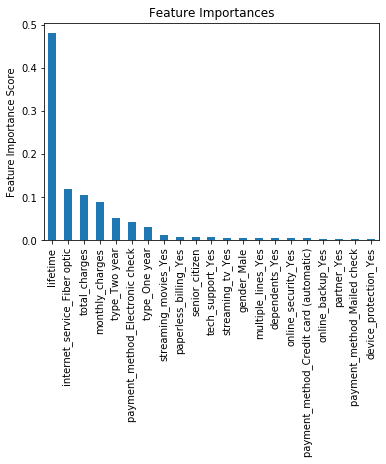

In [53]:
modelfit(model, features_train, target_train)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>хорошо, что используешь этот инструмент. На начальном этапе мы можем нагенерить множество разных фич, в том чтисле и лишних. И вот этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта")

In [54]:
gbc_model = model

model.fit(features_train, target_train)

preds_proba = model.predict_proba(features_valid)[:,1]
print('ROC-AUC score (valid): ', metrics.roc_auc_score(target_valid, preds_proba))

ROC-AUC score (valid):  0.8931424216590457


<b>Вывод:</b> Значение метрики ROC-AUC на валидационной выборке составляет 0.893. Этот результат уже лучше, чем у Random Forest Classifier. Передём к следующей модели.

### Модель XGBoostClassifier

In [55]:
xgb0 = xgb.XGBClassifier(random_state=10, objective='binary:logistic')
modelfit(xgb0, features_train, target_train, printFeatureImportance=False)


Model Report
Accuracy (train) : 0.8412
ROC-AUC Score (Train): 0.901493
CV Score ROC-AUC: Mean - 0.8704273 | Std - 0.01211695 | Min - 0.8581106 | Max - 0.8916314
CV Score Accuracy: Mean - 0.8253262 | Std - 0.01140173 | Min - 0.8144208 | Max - 0.8461538


In [56]:
xgb0.fit(features_train, target_train)

preds_proba = xgb0.predict_proba(features_valid)[:,1]
print('ROC-AUC score (valid): ', metrics.roc_auc_score(target_valid, preds_proba))

ROC-AUC score (valid):  0.8606254359451291


Метрика ROC-AUC на валидационной выборке уже достаточно хорошая, но все равно приступим к настройке гиперпараметров модели.

In [57]:
params_list = [
    {'n_estimators': [i for i in range(290, 350, 10)]},
    {'max_depth': [i for i in range(1, 11, 1)]},
    {'learning_rate': [0.1, 0.01, 0.05, 0.3]},
    {'subsample': [0.8, 0.85, 0.9, 0.95, 1]},
    {'min_child_weight': [i for i in range(0, 7, 1)]},
    {'eta': np.arange(0.1, 1, 0.1)},
    {'colsample_bytree': np.arange(0.5, 1.0, 0.1)},
    {'colsample_bylevel': np.arange(0.5, 1.0, 0.1)},
    {'colsample_bynode': np.arange(0.5, 1.0, 0.1)}
    #{'objective': ['binary:logistic']}
]

model = xgb.XGBClassifier(random_state=10, objective='binary:logistic')

model = tuning(model, params_list, features_train, target_train)

Производится настройка параметра: n_estimators
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:   25.8s remaining:    2.9s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   27.8s finished


Оптимальное значение параметра "n_estimators" равно {'n_estimators': 340}
Производится настройка параметра: max_depth
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.6min finished


Оптимальное значение параметра "max_depth" равно {'max_depth': 4}
Производится настройка параметра: learning_rate
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   22.1s remaining:    5.5s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   25.1s finished


Оптимальное значение параметра "learning_rate" равно {'learning_rate': 0.1}
Производится настройка параметра: subsample
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   31.2s remaining:    5.9s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   35.1s finished


Оптимальное значение параметра "subsample" равно {'subsample': 1}
Производится настройка параметра: min_child_weight
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed:   40.3s remaining:    3.8s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:   42.1s finished


Оптимальное значение параметра "min_child_weight" равно {'min_child_weight': 0}
Производится настройка параметра: eta
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   34.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:   58.7s remaining:    2.7s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   59.1s finished


Оптимальное значение параметра "eta" равно {'eta': 0.1}
Производится настройка параметра: colsample_bytree
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   25.0s remaining:    4.8s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   28.2s finished


Оптимальное значение параметра "colsample_bytree" равно {'colsample_bytree': 0.5}
Производится настройка параметра: colsample_bylevel
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   20.0s remaining:    3.8s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   21.9s finished


Оптимальное значение параметра "colsample_bylevel" равно {'colsample_bylevel': 0.8999999999999999}
Производится настройка параметра: colsample_bynode
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   18.2s remaining:    3.5s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   20.4s finished


Оптимальное значение параметра "colsample_bynode" равно {'colsample_bynode': 0.8999999999999999}


Настройка гиперпараметров завершена. Проверим модель на обучающей и валидационной выборке.


Model Report
Accuracy (train) : 0.916
ROC-AUC Score (Train): 0.970211
CV Score ROC-AUC: Mean - 0.886737 | Std - 0.01481804 | Min - 0.8714898 | Max - 0.9118178
CV Score Accuracy: Mean - 0.8376291 | Std - 0.01183267 | Min - 0.82109 | Max - 0.8556213


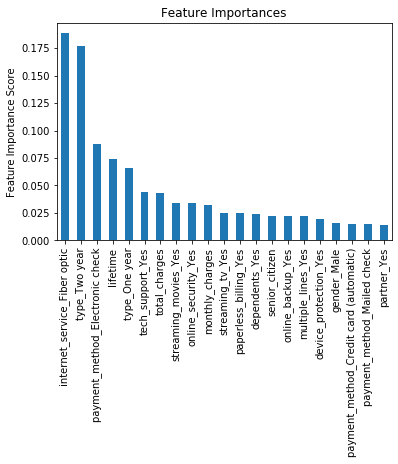

In [58]:
modelfit(model, features_train, target_train)

In [59]:
xgbc_model = model

model.fit(features_train, target_train, eval_metric='auc', eval_set=[(features_valid, target_valid)])

preds_proba = model.predict_proba(features_valid)[:,1]
print('ROC-AUC score (valid): ', metrics.roc_auc_score(target_valid, preds_proba))

[0]	validation_0-auc:0.760885
[1]	validation_0-auc:0.821504
[2]	validation_0-auc:0.822997
[3]	validation_0-auc:0.822284
[4]	validation_0-auc:0.823723
[5]	validation_0-auc:0.826455
[6]	validation_0-auc:0.834209
[7]	validation_0-auc:0.834772
[8]	validation_0-auc:0.837901
[9]	validation_0-auc:0.835183
[10]	validation_0-auc:0.842234
[11]	validation_0-auc:0.843629
[12]	validation_0-auc:0.844155
[13]	validation_0-auc:0.844145
[14]	validation_0-auc:0.844025
[15]	validation_0-auc:0.844381
[16]	validation_0-auc:0.848418
[17]	validation_0-auc:0.848392
[18]	validation_0-auc:0.849569
[19]	validation_0-auc:0.84933
[20]	validation_0-auc:0.848667
[21]	validation_0-auc:0.850722
[22]	validation_0-auc:0.850263
[23]	validation_0-auc:0.84993
[24]	validation_0-auc:0.849792
[25]	validation_0-auc:0.849823
[26]	validation_0-auc:0.849959
[27]	validation_0-auc:0.849265
[28]	validation_0-auc:0.849709
[29]	validation_0-auc:0.850355
[30]	validation_0-auc:0.850177
[31]	validation_0-auc:0.84977
[32]	validation_0-auc

<b>Вывод:</b> Значение метрики ROC-AUC на валидационной выборке равно 0.878. Это хороший результат. В данной модели все признаки обладают определенной важностью, в отличии от предыдущих моделей. Перейдём к сравнению моделей.

## Выбор модели

In [60]:
rfc_model.fit(features_train, target_train)
preds_proba = rfc_model.predict_proba(features_valid)[:,1]
print('Метрика ROC-AUC на валидационной выборке (Random Forest): {:.3f}'.format(metrics.roc_auc_score(target_valid, preds_proba)))

gbc_model.fit(features_train, target_train)
preds_proba = gbc_model.predict_proba(features_valid)[:,1]
print('Метрика ROC-AUC на валидационной выборке (Gradient Boosting): {:.3f}'.format(metrics.roc_auc_score(target_valid, preds_proba)))

xgbc_model.fit(features_train, target_train)
preds_proba = xgbc_model.predict_proba(features_valid)[:,1]
print('Метрика ROC-AUC на валидационной выборке (XGBoost): {:.3f}'.format(metrics.roc_auc_score(target_valid, preds_proba)))

Метрика ROC-AUC на валидационной выборке (Random Forest): 0.839
Метрика ROC-AUC на валидационной выборке (Gradient Boosting): 0.893
Метрика ROC-AUC на валидационной выборке (XGBoost): 0.879


<b>Вывод:</b> Наиболее точная в предсказаниях модель - Gradient Boosting Classifier. Теперь обучим ее на обучающей + валидационной выборке и проверим на тестовой выборке.

In [61]:
gbc_model.fit(features_train.append(features_valid), target_train.append(target_valid))
preds_proba = gbc_model.predict_proba(features_test)[:,1]
print('Метрика ROC-AUC на тестовой выборке (Gradient Boosting): {:.3f}'.format(metrics.roc_auc_score(target_test, preds_proba)))

Метрика ROC-AUC на тестовой выборке (Gradient Boosting): 0.908


<b>Вывод:</b> Метрика ROC-AUC на тестовой выборке равна 0.908.

## Отчёт

Вернуться к "Содержанию":

* [Содержание](#Содержание:)

План выполнения задачи:

* [План выполнения задачи](#План-выполнения-задачи)

***1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?***

- Все пункты плана были выполнены, кроме обработки выбросов, так как во время исследовательского анализа данных не было найдено выбросов.

***2. Какие трудности возникли и как вы их преодолели?***

- Первая трудность возникла на этапе обработки категориальных признаков, изначально некорректно использовал обработку методом OHE. Затем, благодаря совету код-ревьюера, исправил данную недоработку;


- Затем возникла трудность с переобучением моделей, исправил это с помощью подбора гиперпараметров методов GridSearchCV.

***3. Какие ключевые шаги в решении задачи выделили?***

- Первый ключевой шаг - объединение данных;


- Затем последовала корректная обработка категориальных значений, что помогло использовать множество признаков для предсказания модели;


- Ключевым шагом, который помог повысить точность модели, было создание дополнительного признака "lifetime", который указывал на продолжительность контракта;


- Следующий ключевой шаг заключался в разработке функции, которая поэтапно подбирала оптимальные гиперпараметры для каждой модели с помощью GridSearchCV.

***4. Какая ваша итоговая модель и какое у неё качество?***

- Итоговая модель - Gradient Boosting Classifier, ее гиперпараметры приведены ниже;


- Качество модели на тестовой выборке составило (метрика ROC-AUC): 0.908

In [62]:
gbc_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=9,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=12,
                           min_weight_fraction_leaf=0.0, n_estimators=340,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)